# Búsqueda de hiperparámetros para el entrenamiento de DenseNet para una vista (CC/MLO)

Ajustamos el notebook según estemos trabajando en local o en un entorno de Google Colab. Además, seleccionamos la vista sobre la que queremos optimizar el entrenamiento de la red.

In [1]:
google_colab = 0
vista = 'CC' ## 'CC' ó 'MLO'

Importamos todas las librerías necesarias para la implementación de la búsqueda de hiperparámetros de la red.

In [2]:
import tensorflow as tf
import tensorflow.keras as K
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import itertools

if google_colab:
    from google.colab import drive
    !pip install pickle5
    import pickle5 as pickle
    drive.mount('/content/gdrive')

##  Carga del dataset y preparación de los dataset

Definimos una función auxiliar para ayudar con el preprocesamiento de los datos (ajuste de entrada para la DenseNet en el caso de las imágenes y conversión a one-hot encoding para las etiquetas).

In [3]:
def preprocess_data(X, Y):
    """
    Pre-processes the data for the model
        - X is a numpy.ndarray of shape (m, 1024, 1024, 3) containing
         the mammography, where m is the number of data points
        - Y is a numpy.ndarray of shape (m,) containing
         the Bi-Rads labels for X
    Returns:
        - X_p is a numpy.ndarray containing the preprocessed X
        - Y_p is a numpy.ndarray containing the preprocessed Y
    """
    X_p = K.applications.densenet.preprocess_input(X)

    Y_p = K.utils.to_categorical(Y, 3)

    return X_p, Y_p

Cargamos los ficheros de entrada, tanto el de entrenamiento-test como el de validación.

In [4]:
if google_colab:
    with open('/content/gdrive/MyDrive/Colab Notebooks/df_INbreast_train.pkl', 'rb') as pickle_file:
        df_INbreast_train = pickle.load(pickle_file)
    with open('/content/gdrive/MyDrive/Colab Notebooks/df_INbreast_val.pkl', 'rb') as pickle_file:
        df_INbreast_val = pickle.load(pickle_file)
else:
    df_INbreast_train = pd.read_pickle('./df_INbreast_train.pkl')
    df_INbreast_val = pd.read_pickle('./df_INbreast_val.pkl')

if vista == 'CC':
    df_INbreast_train = df_INbreast_train.drop(columns = ['MLO Image']).rename(columns = {'CC Image': 'Image'})
    df_INbreast_val = df_INbreast_val.drop(columns = ['MLO Image']).rename(columns = {'CC Image': 'Image'})
elif vista == 'MLO':
    df_INbreast_train = df_INbreast_train.drop(columns = ['CC Image']).rename(columns = {'MLO Image': 'Image'})
    df_INbreast_val = df_INbreast_val.drop(columns = ['CC Image']).rename(columns = {'MLO Image': 'Image'})

Cargamos los datos, convertimos las etiquetas a enteros y liberamos espacio de los ficheros que contenían el dataset.

In [5]:
dict_valores = {'benigno': 0, 'seguimiento': 1, 'maligno': 2}
Y_traintest = np.array(df_INbreast_train['Bi-Rads'].map(dict_valores).tolist())
X_traintest = np.array(df_INbreast_train['Image'].tolist())
Y_val = np.array(df_INbreast_val['Bi-Rads'].map(dict_valores).tolist())
X_val = np.array(df_INbreast_val['Image'].tolist())
X_val, Y_val = preprocess_data(X_val, Y_val)
del df_INbreast_train
del df_INbreast_val

## Definición de la arquitectura de red neuronal de dos ramas

Definimos la arquitectura de la red neuronal, así como el inicializador y el optimizador que se usarán durante el proceso de entrenamiento. Definimos la capa de entrada de la red, en la cual las imágenes se reescalarán al tamaño definido por la arquitectura DenseNet (256p x 256p).

In [6]:
def DenseNet_1Rama(vista, input_dim = 512, rand_seed = 2021, learning_rate = 0.0001, momentum = 0.9):
    """
    Define the DenseNet architecture and compile the model
        - vista is a mammogram view we want to train
        - input_dim is the size of the mammogram in pixels
        - rand_seed is a random seed number used during the fc layer initialization
        - learning_rate is the learning rate used during the training
        - momentum is the parameters that defines the momentun for the SGD optimizer
    Returns:
        - model_1rama is the output compiled DenseNet model
    """
    # Define the model architecture
    densenet = K.applications.DenseNet121(
        include_top = False,
        weights = "imagenet",
        input_tensor = None,
        input_shape = (256, 256, 3),
        pooling = 'avg'
    )

    densenet.trainable = True

    for layer in densenet.layers:
        if 'conv5' in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False

    input_img = K.Input(shape = (input_dim, input_dim, 3))
    preprocess = K.layers.Lambda(lambda x: tf.image.resize(x, (256, 256)), name = 'resize_' + vista)(input_img)

    initializer = K.initializers.he_normal(seed = rand_seed)
    
    fc_layer = densenet(inputs = preprocess)

    fc_layer = K.layers.Dense(units = 3,
                              activation = 'softmax',
                              kernel_initializer = initializer
                              )(fc_layer)

    model_1rama = K.models.Model(inputs = input_img, outputs = fc_layer)

    # Compile the model
    opt = K.optimizers.SGD(learning_rate = learning_rate, momentum = momentum)
    
    model_1rama.compile(loss = 'categorical_crossentropy',
                        optimizer = opt,
                        metrics = ['accuracy'])
    
    return model_1rama

Mostramos por pantalla la arquitectura de la red definida.

In [7]:
DenseNet_1Rama(vista).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
resize_CC (Lambda)           (None, 256, 256, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 2,161,155
Non-trainable params: 4,879,424
_________________________________________________________________


## Entrenamiento de la red neuronal

Definimos una función auxiliar que particiona el conjunto de entrenamiento/test en los dos subconjuntos correspondientes (entrenamiento y test).

In [8]:
def part_traintest(X_traintest, Y_traintest, rand_seed = 2021, frac_test = .2/.8):
    """
    Function that makes a partition for training and testing from the original dataset
        - X_traintest is the array of images from the original dataset
        - Y_traintest is the array of labels from the original dataset
        - rand_seed is a random seed number used during the sampling
        - frac_test is the fraction of cases used in the test subset
    Returns:
        - X_train is the train array of images
        - Y_train is the train array of labels
        - X_test is the test array of images
        - Y_test is the test array of labels
    """
    np.random.seed(rand_seed)
    index_test = np.array([], dtype = 'int64')
    for i in np.unique(Y_traintest):
        index_test = np.append(index_test, 
                               np.random.choice(list(np.where(Y_traintest == i)[0]), size = int(np.where(Y_traintest == i)[0].shape[0]*frac_test), replace = False))
    X_train = np.delete(X_traintest, index_test, axis = 0)
    Y_train = np.delete(Y_traintest, index_test)
    X_test = np.take(X_traintest, index_test, axis = 0)
    Y_test = np.take(Y_traintest, index_test)
    X_train, Y_train = preprocess_data(X_train, Y_train)
    X_test, Y_test = preprocess_data(X_test, Y_test)

    return X_train, Y_train, X_test, Y_test

Definimos los parámetros básicos para el proceso de entrenamiento.

In [9]:
batch_size = 16
no_epochs = 300
input_dim = X_traintest.shape[1]
rand_seed = 2021
n_folds = 3
frac_test = .2/.8

Dado el desbalance que sufren las categorías de la muestra de entrenamiento, forzamos el balanceo calculando las proporciones respecto a la clase más representada.

In [10]:
label, counts = np.unique(Y_traintest, return_counts = True)
class_weight = {}
for lab, con in zip(label, counts):
  class_weight.update({lab: round(max(counts)/con, 2)})

Definimos un callback para el entrenamiento de la red, de tal manera que nos aseguramos que el entrenamiento disminuye el learning rate cuando la pérdida sobre el conjutno de test ya no disminuye y detenemos el entrenamiento cuando dich pérdida tampoco disminuye.

In [11]:
early_stopping = EarlyStopping(patience = 20, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(factor = 0.5, patience = 5)

Iteramos la definición y el entrenamiento de la red para no sesgar los resultados según el conjunto de entrenamiento y de test escogido en cada caso. Almacenamos el output de cada iteración para poder representarlos más adelante, evaluando cada red obtenida mediante el conjunto de validación.

In [12]:
learn_rate = [0.01, 0.005, 0.001, 0.0005, 0.0001]
momentum = [0, 0.2, 0.5, 0.8, 0.9]

tot_comb = len(learn_rate) * len(momentum)
glob_param = np.empty([tot_comb, 2])

history_list = []
scores_glob_array = np.empty([tot_comb, n_folds, 2])

for idx, x in enumerate(itertools.product(learn_rate, momentum)):
    learn_rate = x[0]
    momentum = x[1]

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for combination {idx + 1}/{tot_comb} ...')
    print(f'Learning rate = {learn_rate}')
    print(f'Momentum = {momentum}')
    print('------------------------------------------------------------------------')

    history_array = np.array([])
    scores_array = np.empty([n_folds, 2])

    glob_param[idx, 0] = learn_rate
    glob_param[idx, 1] = momentum

    for fold in range(n_folds):
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold + 1}/{n_folds} ...')
        print('------------------------------------------------------------------------')

        # Generate the fold sample for train-test
        X_train, Y_train, X_test, Y_test = part_traintest(X_traintest, Y_traintest, rand_seed + fold, frac_test)
        
        # Define the model architecture
        model_1rama = DenseNet_1Rama(vista, input_dim, rand_seed, learn_rate, momentum)
        
        # Fit data to model
        history = model_1rama.fit(X_train, Y_train,
                                  batch_size = batch_size,
                                  epochs = no_epochs,
                                  validation_data = (X_test, Y_test),
                                  class_weight = class_weight,
                                  verbose = 1,
                                  callbacks = [early_stopping, reduce_lr])

        # Generate generalization metrics
        scores_array[fold, :] = model_1rama.evaluate(X_val, Y_val, verbose = 0)
        print('------------------------------------------------------------------------')
        print(f'Score for fold {fold + 1}: {model_1rama.metrics_names[0]} of {round(scores_array[fold, 0], 2)}; {model_1rama.metrics_names[1]} of {round(scores_array[fold, 1]*100, 2)}%')
        print('------------------------------------------------------------------------')
        print('')
        
        # Append history callback into array
        history_array = np.append(history_array, [history])
        
    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, scores_array.shape[0]):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i + 1} - Loss: {round(scores_array[i, 0], 2)} - Accuracy: {round(scores_array[i, 1], 2)}%')
    print('------------------------------------------------------------------------')
    print(f'Average scores for all folds (LR = {learn_rate}, mtm = {momentum}):')
    print(f'> Accuracy: {round(np.mean(scores_array[:, 1]), 2)} (+- {round(np.std(scores_array[:, 1]), 2)})')
    print(f'> Loss: {round(np.mean(scores_array[:, 0]), 2)} (+- {round(np.std(scores_array[:, 0]), 2)})')
    print('------------------------------------------------------------------------')
    print('')
    print('')

    idx_best_hist = np.argmax(scores_array[:, 1])
    history_list.append(history_array[idx_best_hist])
    
    scores_glob_array[idx, :, :] = scores_array

Streaming output truncated to the last 5000 lines.
10/10 [==============================] - 1s 118ms/step - loss: 0.6708 - accuracy: 0.8005 - val_loss: 2.6796 - val_accuracy: 0.5000
Epoch 10/300
10/10 [==============================] - 1s 117ms/step - loss: 0.9473 - accuracy: 0.7809 - val_loss: 6.3153 - val_accuracy: 0.4423
Epoch 11/300
10/10 [==============================] - 1s 119ms/step - loss: 0.5332 - accuracy: 0.7646 - val_loss: 1.3170 - val_accuracy: 0.6538
Epoch 12/300
10/10 [==============================] - 1s 122ms/step - loss: 0.1188 - accuracy: 0.9455 - val_loss: 1.3774 - val_accuracy: 0.6538
Epoch 13/300
10/10 [==============================] - 1s 120ms/step - loss: 0.2337 - accuracy: 0.9933 - val_loss: 1.7600 - val_accuracy: 0.5962
Epoch 14/300
10/10 [==============================] - 1s 122ms/step - loss: 0.0322 - accuracy: 1.0000 - val_loss: 1.5245 - val_accuracy: 0.6731
Epoch 15/300
10/10 [==============================] - 1s 124ms/step - loss: 0.0236 - accuracy: 1.0

## Representación de resultados

Definimos una serie de funciones auxiliares para facilitar la visualización de resultados (representación de la evolución de las métricas durante el proceso de entrenamiento y resultados de la matriz de confusión finalmente obtenida).

In [13]:
def plot_metrics(history):
    """
    Function that plots the metrics from the training process
        - history is the output from the training process
    """
    fig = plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper right')
    
    plt.show()
    return

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """
    Credit to:
    https://gist.github.com/zachguo/10296432
    
    Function that makes a pretty print for confusion matrixes
        - cm is the array of histories generated during the training process
        - labels is number of epochs fixed for the training process
        - hide_zeroes is a boolean that allows the user to hide the zeroes in the matrix
        - hide_diagonal is a boolean that allows the user to hide the diagonal in the matrix
        - hide_threshold is a number that allows the user to hide results in the matrix below that value
    """
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()
    return

Mostramos por pantalla los resultados medios de todas las combinaciones de parámetros y elegimos el modelo que mejores resultados ofrece.

In [14]:
print(f'Resultados promedios del entrenamiento DenseNet-{vista}:')
for i in range(len(glob_param)):
    print(f'- LR={glob_param[i, 0]} / mom={glob_param[i, 1]}:\tAcc={round(np.mean(scores_glob_array[i, :, 1]), 2)} (+- {round(np.std(scores_glob_array[i, :, 1]), 2)}) - Loss={round(np.mean(scores_glob_array[i, :, 0]), 2)} (+- {round(np.std(scores_glob_array[i, :, 0]), 2)})')

idx_best = np.argmax(np.mean(scores_glob_array, 1)[:, 1])
history_best = history_list[idx_best]
model_best = history_best.model
print(f'\nEl mejor resultado para la DenseNet-{vista} se obtiene para LR = {glob_param[idx_best, 0]} y momentum = {glob_param[idx_best, 1]}.')

Resultados promedios del entrenamiento DenseNet-CC:
- LR=0.01 / mom=0.0:	Acc=0.7 (+- 0.04) - Loss=0.77 (+- 0.09)
- LR=0.01 / mom=0.2:	Acc=0.65 (+- 0.07) - Loss=0.82 (+- 0.03)
- LR=0.01 / mom=0.5:	Acc=0.68 (+- 0.09) - Loss=0.82 (+- 0.05)
- LR=0.01 / mom=0.8:	Acc=0.64 (+- 0.07) - Loss=0.95 (+- 0.05)
- LR=0.01 / mom=0.9:	Acc=0.51 (+- 0.07) - Loss=1.32 (+- 0.45)
- LR=0.005 / mom=0.0:	Acc=0.63 (+- 0.04) - Loss=0.76 (+- 0.01)
- LR=0.005 / mom=0.2:	Acc=0.65 (+- 0.02) - Loss=0.79 (+- 0.03)
- LR=0.005 / mom=0.5:	Acc=0.67 (+- 0.02) - Loss=0.76 (+- 0.04)
- LR=0.005 / mom=0.8:	Acc=0.6 (+- 0.1) - Loss=0.85 (+- 0.07)
- LR=0.005 / mom=0.9:	Acc=0.6 (+- 0.03) - Loss=1.31 (+- 0.63)
- LR=0.001 / mom=0.0:	Acc=0.62 (+- 0.02) - Loss=0.8 (+- 0.02)
- LR=0.001 / mom=0.2:	Acc=0.64 (+- 0.03) - Loss=0.79 (+- 0.02)
- LR=0.001 / mom=0.5:	Acc=0.65 (+- 0.02) - Loss=0.78 (+- 0.03)
- LR=0.001 / mom=0.8:	Acc=0.67 (+- 0.01) - Loss=0.76 (+- 0.02)
- LR=0.001 / mom=0.9:	Acc=0.65 (+- 0.0) - Loss=0.79 (+- 0.02)
- LR=0.0005 / 

Visualizamos la evolución de las métricas durante el proceso de entrenamiento de la red con mejores resultados.

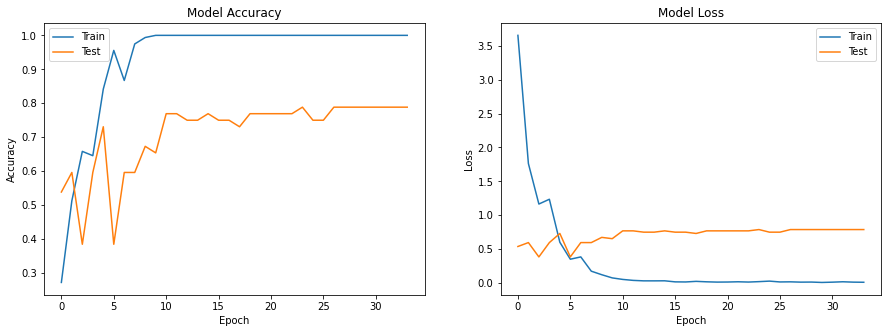

In [15]:
plot_metrics(history_best)

Mostramos la matriz de confusión de la última iteración por pantalla.

In [16]:
conf_matrix = metrics.confusion_matrix(Y_val.argmax(axis = 1), model_best.predict(X_val).argmax(axis = 1))
print_cm(conf_matrix, list(dict_valores.keys()))

            benigno seguimiento  maligno 
    benigno    24.0         1.0      3.0 
seguimiento     3.0         0.0      1.0 
    maligno     5.0         0.0     15.0 


Mostramos las métricas de resultados según categoría para poder evaluar el desempeño de la red en cada caso.

In [17]:
classif_report = metrics.classification_report(Y_val.argmax(axis = 1), model_best.predict(X_val).argmax(axis = 1),
                                               target_names = list(dict_valores.keys()))
print(classif_report)

              precision    recall  f1-score   support

     benigno       0.75      0.86      0.80        28
 seguimiento       0.00      0.00      0.00         4
     maligno       0.79      0.75      0.77        20

    accuracy                           0.75        52
   macro avg       0.51      0.54      0.52        52
weighted avg       0.71      0.75      0.73        52



Guardamos el modelo entrenado para su uso en pasos posteriores.

In [18]:
if google_colab:
    file_path = '/content/gdrive/MyDrive/Colab Notebooks/' + 'model_best_' + vista
else:
    file_path = './model_best_' + vista
K.models.save_model(model_best, file_path)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/model_best_CC/assets
